### Computing azimutal shear with linear least squares derivatives (LLSD)

This is a brief notebook showing how to compute the azimuthal shear using the LLSD methodology from Smith and Elmore (2004), and Miller et al. (2013). 
You will need to install the PyMeso package from here https://github.com/jordanbrook/PyMeso.

#### References:

<div class="csl-entry">Smith, T. M., &#38; Elmore, K. L. (2004). THE USE OF RADIAL VELOCITY DERIVATIVE TO DIAGNOSE ROTATION AND DIVERGENCE. <i>11th Conference on Aviation, Range, and Aerospace</i>.</div>

<div class="csl-entry">Miller, M. L., Lakshmanan, V., &#38; Smith, T. M. (2013). An automated method for depicting mesocyclone paths and intensities. <i>Weather and Forecasting</i>, <b>28</b>(3), 570–585</div>

In [4]:
import matplotlib.pyplot as plt
import pyart 
import numpy as np
from vcor_dual_prf import correct_dualprf
from pymeso import llsd
from vel_correction import staggered_to_dual, smooth_vel

Read the volume from the Santiago 

In [8]:
radar = pyart.aux_io.read_gamic('R13557476_202212121640.hdf5')

Correct the catastrophic errors

In [9]:
staggered_to_dual(radar)

In [10]:
correct_dualprf(radar=radar, two_step=True,
                     method_det='cmean', kernel_det=np.ones((11, 11)),
                     method_cor='cmean', kernel_cor=np.ones((5, 5)),
                     vel_field='corrected_velocity', new_field='vcor_cmean', replace=True)

radar.fields['vcor_cmean']['units'] = 'meters_per_second'
radar.fields['vcor_cmean']['standard_name'] = 'corrected_radial_velocity_of_scatterers_away_from_instrument'
radar.fields['vcor_cmean']['long_name'] = 'Corrected mean doppler velocity'
radar.fields['vcor_cmean']['coordinates'] = 'elevation azimuth range'

/home/viper/CENSIPAM/vcor_dual_prf.py:234: RuntimeWarning: invalid value encountered in divide
  avg_ma = np.ma.array(data=sum_arr/valid_num, mask=mask)


In [11]:
smooth_vel(radar)

Evaluate the azimuthal shear. As this radar has a 2° beamwidth, we will need a larger window size

In [12]:
azi_shear = llsd.main(radar, ref_name='corrected_reflectivity', vel_name='vcor_cmean_smooth', window_size=(750, 6000))

/home/viper/miniconda3/envs/py39/lib/python3.9/site-packages/pymeso/llsd.py:27: DeprecationWarning: Please use `median_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smooth_data    = scipy.ndimage.filters.median_filter(data, 3)


Add the field to radar object

In [13]:
radar.add_field('azi_shear', azi_shear, replace_existing=True)

Plot the results

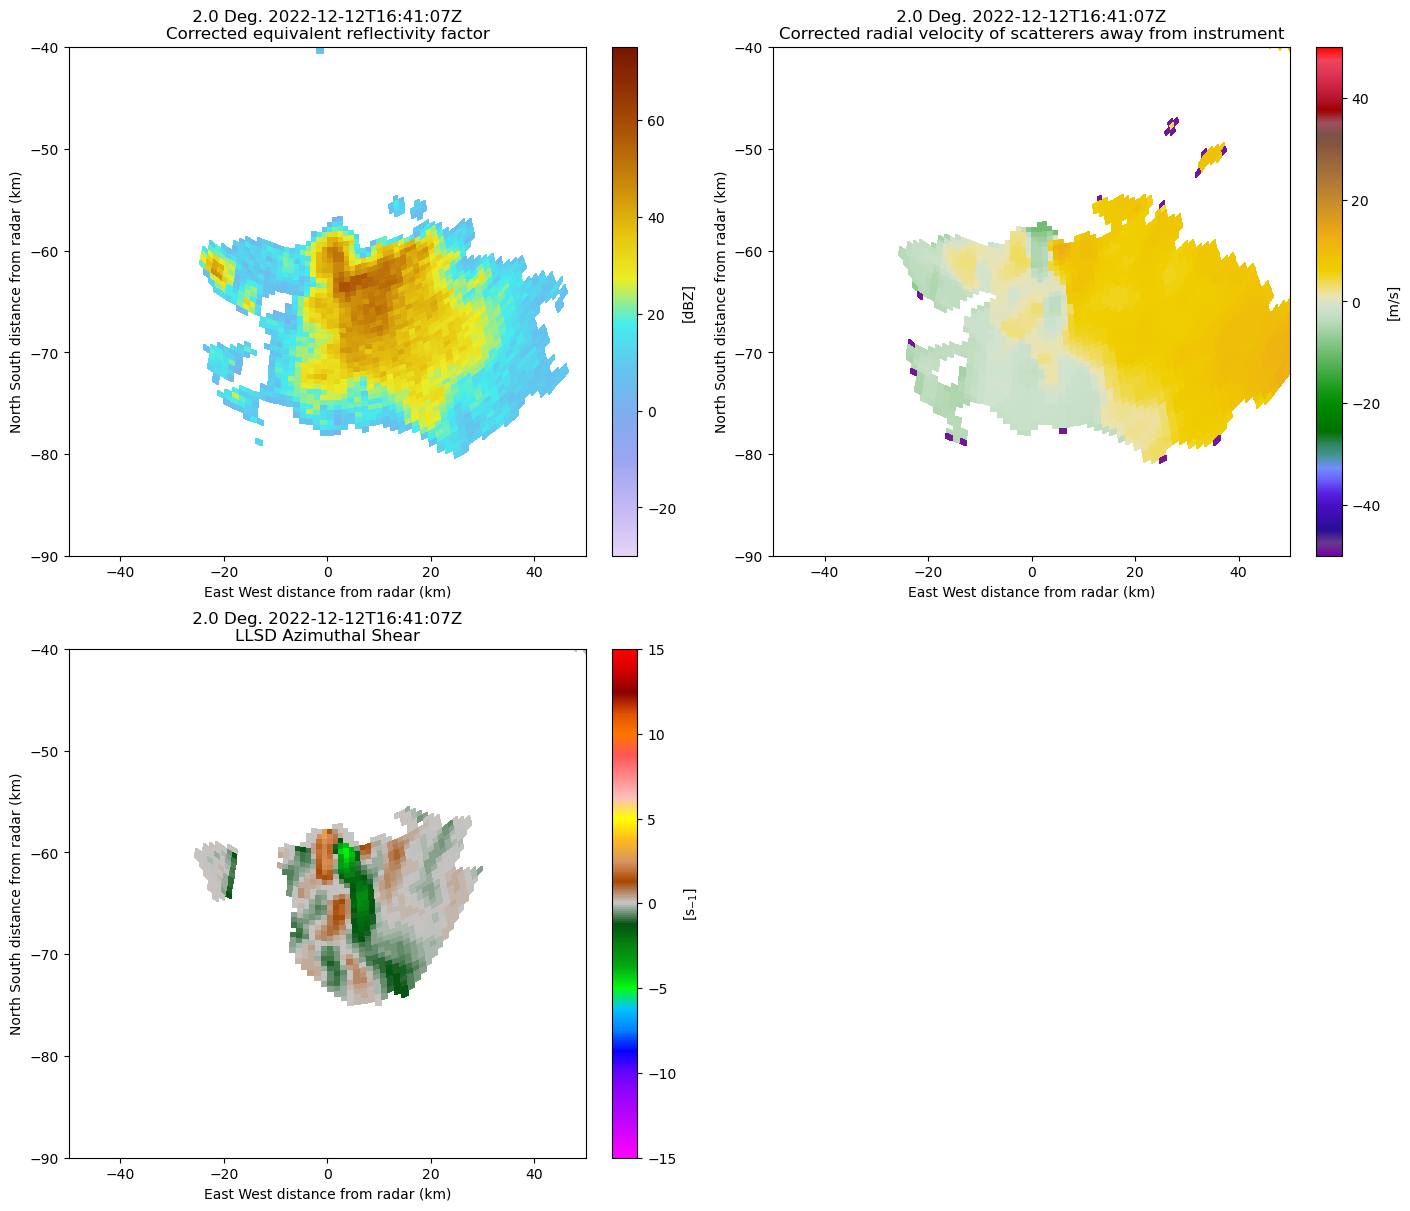

In [19]:
fig, axs = plt.subplots(2, 2, figsize=[14, 12], constrained_layout=True)

axs.ravel()[3].set_axis_off()

for ax in axs.ravel():
    ax.set_xlim(-50, 50)
    ax.set_ylim(-90, -40)

display = pyart.graph.RadarDisplay(radar)
display.plot('corrected_reflectivity', 2, cmap = pyart.graph.cm.LangRainbow12, ax = axs.ravel()[0], colorbar_label='[dBZ]')
display.plot('vcor_cmean_smooth', 2, vmin = -50, vmax = 50, cmap = pyart.graph.cm.Carbone42, ax = axs.ravel()[1], colorbar_label='[m/s]')
display.plot('azi_shear', 2, vmin = -15, vmax = 15, cmap = pyart.graph.cm.Wild25, ax = axs.ravel()[2], colorbar_label='[s$_{-1}$]')

plt.savefig('/mnt/g/My Drive/DIPTC/relatório/azi_shear.png', dpi = 300, bbox_inches = 'tight')